In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib
import numpy as np
import os
from nb import NaiveBayesGaussian

In [20]:
df_train = pd.read_csv('../dataset/train.csv', delimiter=";")
df_test = pd.read_csv('../dataset/test.csv', delimiter=";")

df_test.head()

,protocol,pkt_length,pkt_rate,pkt_count,ip_ttl,status
0,ICMP,73,1000,59078,64,DDOS-Attack
1,ICMP,83,1000,59151,64,DDOS-Attack
2,UDP,901,140,8515,32,Normal
3,ICMP,74,2713,163581,64,DDOS-Attack
4,UDP,76,10333,623891,64,DDOS-Attack


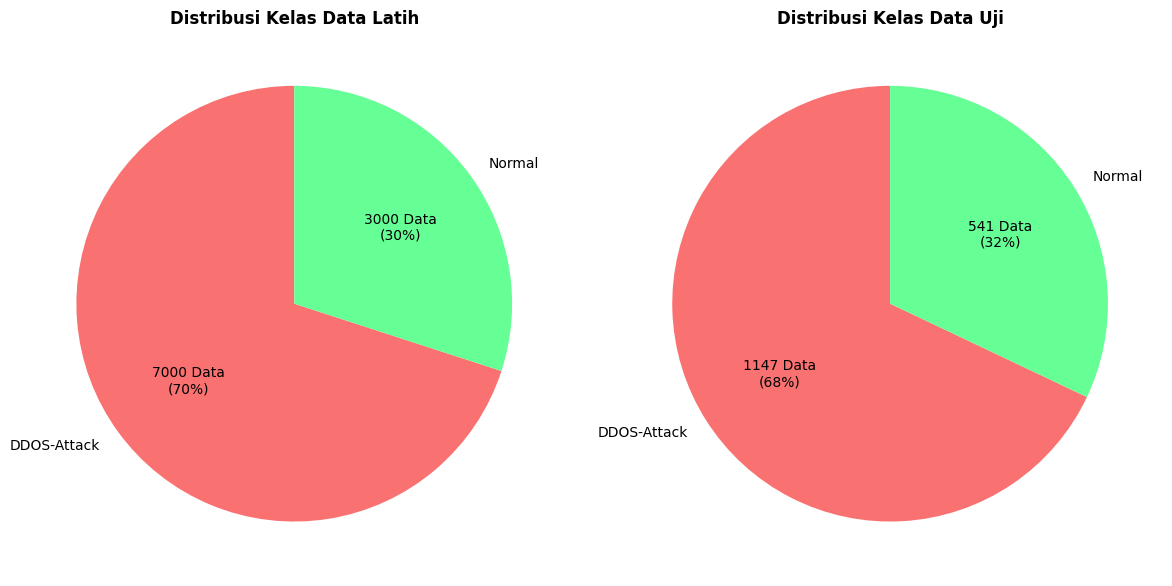

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

label_counts_train = df_train['status'].value_counts()
labels_train = label_counts_train.index
sizes_train = label_counts_train.values

axes[0].pie(
    sizes_train,
    labels=labels_train,
    autopct=lambda pct: f"{int(round(pct/100.*sum(sizes_train)))} Data\n({pct:.0f}%)",
    startangle=90,
    colors=["#fa7171", "#66ff96"]
)
axes[0].set_title("Distribusi Kelas Data Latih", fontsize=12, fontweight="bold")

label_counts_test = df_test['status'].value_counts()
labels_test = label_counts_test.index
sizes_test = label_counts_test.values

axes[1].pie(
    sizes_test,
    labels=labels_test,
    autopct=lambda pct: f"{int(round(pct/100.*sum(sizes_test)))} Data\n({pct:.0f}%)",
    startangle=90,
    colors=["#fa7171", "#66ff96"]
)
axes[1].set_title("Distribusi Kelas Data Uji", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

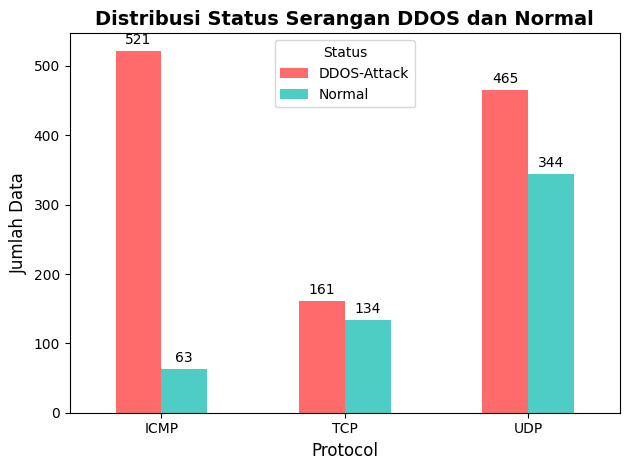

In [22]:
protocol_status = df_test.groupby(['protocol', 'status']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
protocol_status.plot(kind='bar', color=['#ff6b6b', '#4ecdc4'])
plt.title('Distribusi Status Serangan DDOS dan Normal', fontsize=14, fontweight='bold')
plt.xlabel('Protocol', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.legend(title='Status')
plt.xticks(rotation=0)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

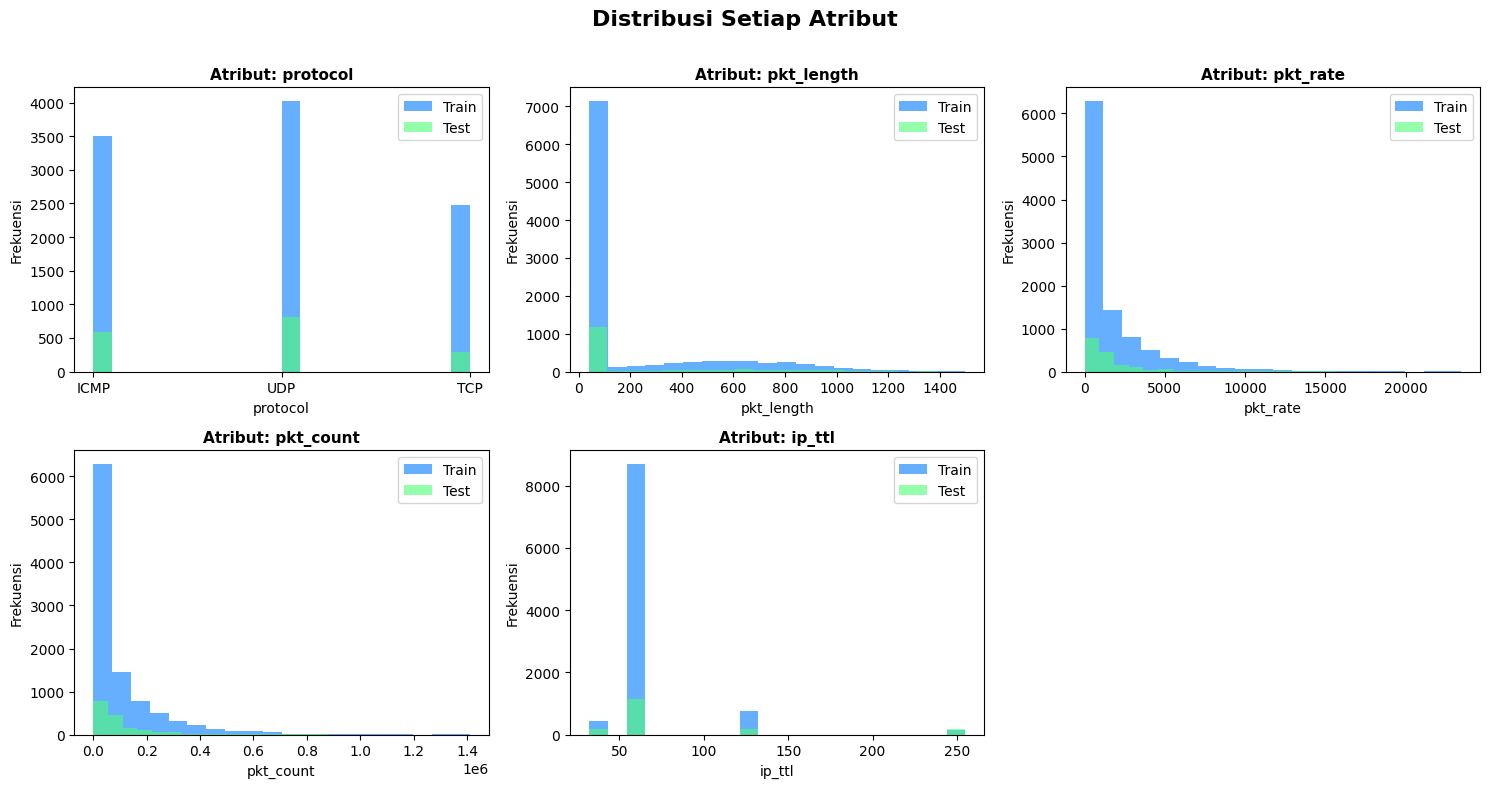

In [23]:
columns = df_train.columns[:-1]

num_cols = len(columns)
n_cols = 3
n_rows = int(np.ceil(num_cols / n_cols))

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    plt.hist(
        df_train[col],
        bins=20,
        alpha=0.6,
        label="Train",
        color="#007bff"  
    )
    
    plt.hist(
        df_test[col],
        bins=20,
        alpha=0.6,
        label="Test",
        color="#4dff74"  
    )
    
    plt.title(f"Atribut: {col}", fontsize=11, fontweight="bold")
    plt.xlabel(col)
    plt.ylabel("Frekuensi")
    plt.legend()

plt.suptitle("Distribusi Setiap Atribut", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [24]:
label_encoder = LabelEncoder()
df_train['status'] = label_encoder.fit_transform(df_train['status'])

protocol_encoder = LabelEncoder()
df_train['protocol'] = protocol_encoder.fit_transform(df_train['protocol'])

protocol_mapping = {'ICMP': 0, 'TCP': 1, 'UDP': 2}
df_test['protocol'] = df_test['protocol'].map(protocol_mapping)

status_mapping = {'DDOS-Attack': 0, 'Normal': 1}
df_test['status'] = df_test['status'].map(status_mapping)

In [25]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [26]:
def format_number(x):
    s = f"{x:.4f}"
    return s.rstrip('0').rstrip('.')

def format_percent(x):
    p = x * 100
    s = f"{p:.2f}"
    return s.rstrip('0').rstrip('.') + "%"

classes = y_train.unique()
priors = {c: len(y_train[y_train == c]) / len(y_train) for c in classes}

print("=== PRIOR PROBABILITY ===")
for c, p in priors.items():
    print(f"P({c}) = {format_number(p)} ({format_percent(p)})")

=== PRIOR PROBABILITY ===
P(0) = 0.7 (70%)
P(1) = 0.3 (30%)


In [27]:
mean = {}
var = {}

for c in classes:
    data_c = X_train[y_train == c]
    mean[c] = data_c.mean()
    var[c]  = data_c.var()

atribut_labels = ["X1", "X2", "X3", "X4", "X5"]

df_stats = pd.DataFrame({
    "Variabel": atribut_labels,
    "Mean Class 0": mean[0].values,
    "Mean Class 1": mean[1].values,
    "Variasi Class 0": var[0].values,
    "Variasi Class 1": var[1].values
})

styled_table = (
    df_stats.style
        .set_properties(
            **{
                'border': '1px solid black',
                'text-align': 'center',
                'padding': '6px'
            }
        )
        .set_table_styles(
            [
                {'selector': 'th',
                 'props': [('border', '1px solid black'),
                           ('text-align', 'center'),
                           ('font-weight', 'bold'),
                           ('background-color', "#f2f2f200")]}
            ]
        )
)

styled_table

,Variabel,Mean Class 0,Mean Class 1,Variasi Class 0,Variasi Class 1
0,X1,0.987857,1.202667,0.900981,0.365715
1,X2,69.521714,602.707333,215.490027,88541.562200
2,X3,2416.137143,80.634667,6821957.812308,3110.626074
3,X4,144974.029857,4841.954667,24573118412.092407,11160153.080972
4,X5,64.009143,83.869667,0.585143,2406.470170


In [28]:
def gaussian_likelihood(x, mean, var):
    eps = 1e-6
    coeff = 1.0 / np.sqrt(2 * np.pi * (var + eps))
    exponent = np.exp(- (x - mean)**2 / (2 * (var + eps)))
    return coeff * exponent

In [29]:
save_dir = "result/perhitungan"
os.makedirs(save_dir, exist_ok=True)

results = []
full_logs = []

feature_names = X_test.columns 

for idx, row in X_test.iterrows():

    idx += 1
    
    likelihoods_per_class = {}
    feature_likelihoods_per_class = {}

    for c in classes:

        feature_likelihoods = gaussian_likelihood(
            row.values,
            mean[c].values,
            var[c].values
        )

        total_likelihood = np.prod(feature_likelihoods)

        likelihoods_per_class[c] = total_likelihood
        feature_likelihoods_per_class[c] = feature_likelihoods

    results.append({
        "Index": idx,
        "Likelihood Class 0": likelihoods_per_class[0],
        "Likelihood Class 1": likelihoods_per_class[1],
    })

    class0_lines = ""
    for i, val in enumerate(feature_likelihoods_per_class[0]):
        class0_lines += f"X{i+1} = {val}\n"

    class1_lines = ""
    for i, val in enumerate(feature_likelihoods_per_class[1]):
        class1_lines += f"X{i+1} = {val}\n"

    log_text = (
        f"Aktifitas: {idx}\n\n"
        f"=== Class 0 ===\n"
        f"{class0_lines}\n"
        f"=== Class 1 ===\n"
        f"{class1_lines}\n"
        f"{'-'*100}\n\n"
    )

    full_logs.append(log_text)

df_results = pd.DataFrame(results)

file_path = f"{save_dir}/hasil_likelihood_naive_bayes.txt"
with open(file_path, "w") as f:
    f.write("=== HASIL PERHITUNGAN LIKELIHOOD NAIVE BAYES ===\n\n")
    for entry in full_logs:
        f.write(entry)

print("File berhasil disimpan di:")
print(file_path)

File berhasil disimpan di:
result/perhitungan/hasil_likelihood_naive_bayes.txt


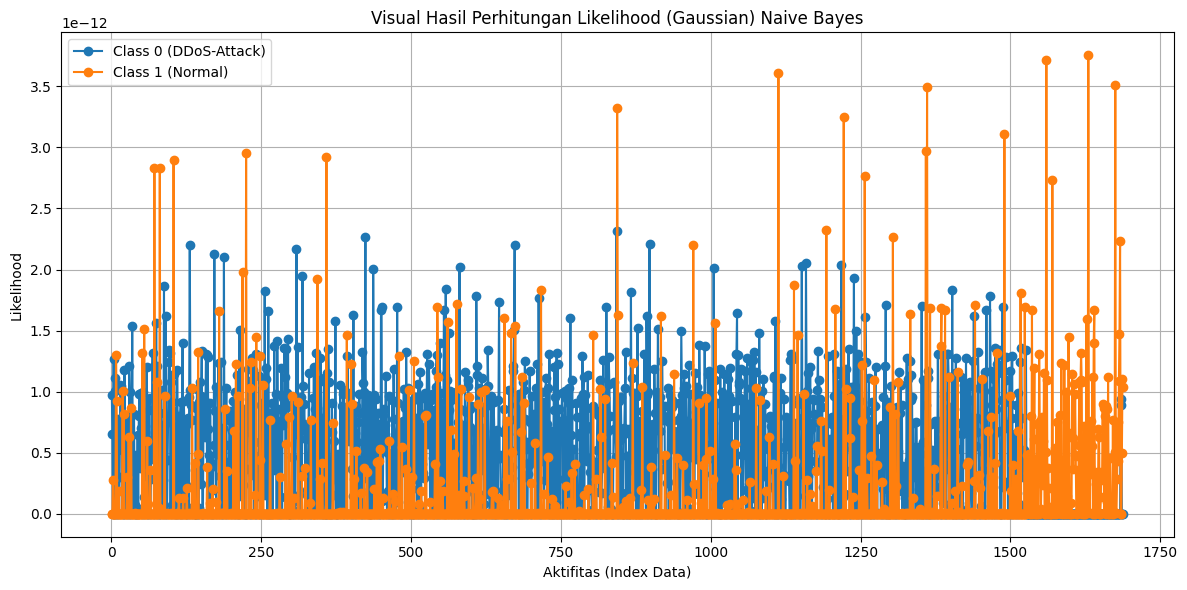

In [30]:
plt.figure(figsize=(12, 6))

plt.plot(df_results["Index"], df_results["Likelihood Class 0"], marker='o', label="Class 0 (DDoS-Attack)")
plt.plot(df_results["Index"], df_results["Likelihood Class 1"], marker='o', label="Class 1 (Normal)")

plt.title("Visual Hasil Perhitungan Likelihood (Gaussian) Naive Bayes")
plt.xlabel("Aktifitas (Index Data)")
plt.ylabel("Likelihood")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
results_posterior = []
full_logs_posterior = []

for idx, row in X_test.iterrows():

    idx += 1

    likelihoods_per_class = {}
    posteriors_per_class = {}
    feature_likelihoods_per_class = {}

    for c in classes:

        feature_likelihoods = gaussian_likelihood(
            row.values,
            mean[c].values,
            var[c].values
        )

        total_likelihood = np.prod(feature_likelihoods)
        posterior = priors[c] * total_likelihood

        likelihoods_per_class[c] = total_likelihood
        posteriors_per_class[c] = posterior
        feature_likelihoods_per_class[c] = feature_likelihoods

    results_posterior.append({
        "Index": idx,
        "Posterior Class 0": posteriors_per_class[0],
        "Posterior Class 1": posteriors_per_class[1],
        "Predicted": 0 if posteriors_per_class[0] > posteriors_per_class[1] else 1
    })

    class0_lines = ""
    for i, val in enumerate(feature_likelihoods_per_class[0]):
        class0_lines += f"X{i+1} = {val}\n"

    class1_lines = ""
    for i, val in enumerate(feature_likelihoods_per_class[1]):
        class1_lines += f"X{i+1} = {val}\n"

    log_text = (
        f"Aktifitas: {idx}\n\n"
        f"Posterior Class 0 = {posteriors_per_class[0]}\n"
        f"Posterior Class 1 = {posteriors_per_class[1]}\n"
        f"{'-'*100}\n\n"
    )

    full_logs_posterior.append(log_text)


df_results_posterior = pd.DataFrame(results_posterior)

file_path_posterior = f"{save_dir}/hasil_posterior_naive_bayes.txt"
with open(file_path_posterior, "w") as f:
    f.write("=== HASIL PERHITUNGAN PROBABILITAS POSTERIOR NAIVE BAYES ===\n\n")
    for entry in full_logs_posterior:
        f.write(entry)

print("File posterior berhasil disimpan di:")
print(file_path_posterior)

File posterior berhasil disimpan di:
result/perhitungan/hasil_posterior_naive_bayes.txt


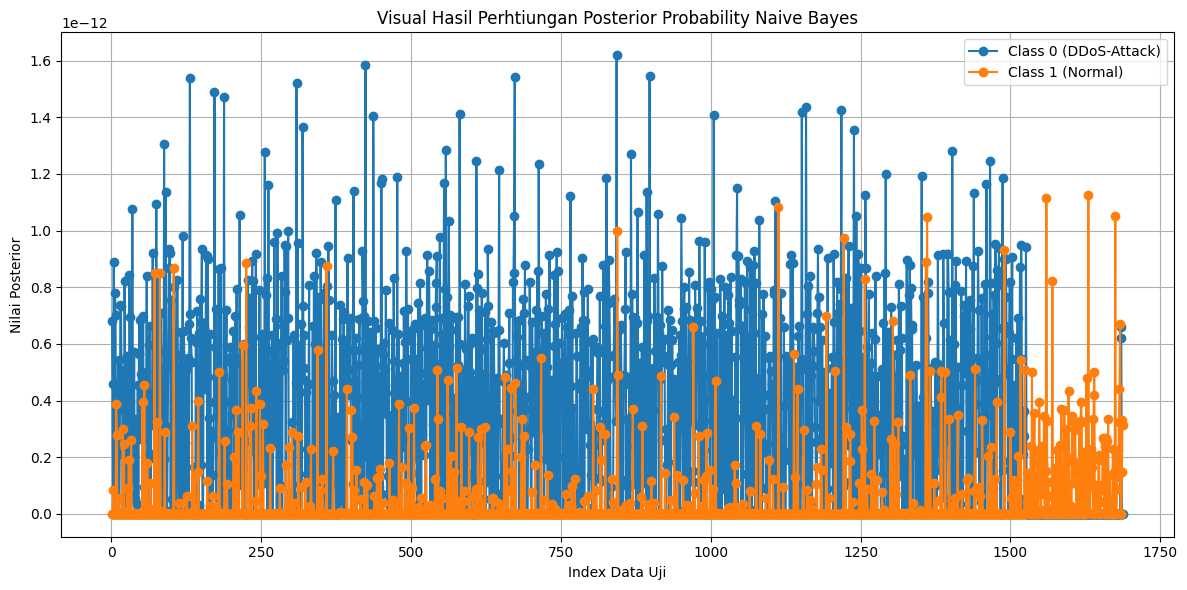

In [32]:
plt.figure(figsize=(12, 6))

plt.plot(df_results_posterior["Index"], df_results_posterior["Posterior Class 0"],
         marker='o', label="Class 0 (DDoS-Attack)")

plt.plot(df_results_posterior["Index"], df_results_posterior["Posterior Class 1"],
         marker='o', label="Class 1 (Normal)")

plt.title("Visual Hasil Perhtiungan Posterior Probability Naive Bayes")
plt.xlabel("Index Data Uji")
plt.ylabel("Nilai Posterior")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
classification_logs = []
classification_results = []

for idx, row in df_results_posterior.iterrows():

    actual = y_test.iloc[idx]          
    predicted = int(round(row["Predicted"], 0))

    posterior_0 = row["Posterior Class 0"]
    posterior_1 = row["Posterior Class 1"]

    actual_label = "DDoS-Attack" if actual == 0 else "Normal"
    predicted_label = "DDoS-Attack" if predicted == 0 else "Normal"

    classification_results.append({
        "Index": int(row["Index"]),
        "Actual": actual,
        "Predicted": predicted,
        "Posterior Class 0": posterior_0,
        "Posterior Class 1": posterior_1
    })

    log_line = (
        f"Aktifitas: {int(row['Index'])}\n"
        f"Posterior Class 0  : {posterior_0}\n"
        f"Posterior Class 1  : {posterior_1}\n"
        f"Y Aktual           : {actual} ({actual_label})\n"
        f"Y Prediksi         : {predicted} ({predicted_label})\n"
        f"{'-'*60}\n\n"
    )

    classification_logs.append(log_line)


df_classification = pd.DataFrame(classification_results)

file_path_class = f"{save_dir}/hasil_klasifikasi_naive_bayes.txt"
with open(file_path_class, "w") as f:
    f.write("=== HASIL KLASIFIKASI NAIVE BAYES ===\n\n")
    for entry in classification_logs:
        f.write(entry)

print("File klasifikasi berhasil disimpan di:")
print(file_path_class)

File klasifikasi berhasil disimpan di:
result/perhitungan/hasil_klasifikasi_naive_bayes.txt


<Figure size 600x500 with 0 Axes>

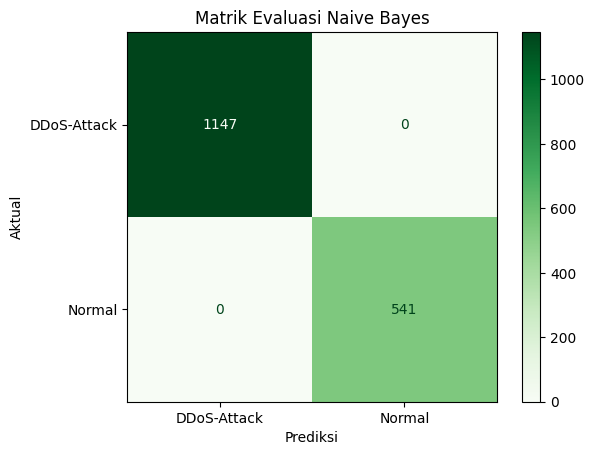

In [34]:
y_actual = df_classification["Actual"].values
y_pred = df_classification["Predicted"].values

cm = confusion_matrix(y_actual, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["DDoS-Attack", "Normal"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Greens', colorbar=True)
plt.title("Matrik Evaluasi Naive Bayes")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [35]:
def format_metric(value):
    if value in [0, 1]:
        return f"{value:.0f} (Presentase: {value*100:.0f}%)"
    else:
        return f"{value:.4f} (Presentase: {value*100:.2f}%)"

y_actual = df_classification["Actual"].values
y_pred = df_classification["Predicted"].values

accuracy = accuracy_score(y_actual, y_pred)
precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f"Accuracy  = {format_metric(accuracy)}")
print(f"Precision = {format_metric(precision)}")
print(f"Recall    = {format_metric(recall)}")
print(f"F1-Score  = {format_metric(f1)}")

Accuracy  = 1 (Presentase: 100%)
Precision = 1 (Presentase: 100%)
Recall    = 1 (Presentase: 100%)
F1-Score  = 1 (Presentase: 100%)


In [36]:
feature_columns = ['protocol', 'pkt_rate', 'pkt_length', 'pkt_count', 'ip_ttl']

X_train_nb = X_train[feature_columns]

mean = {}
var = {}
classes = y_train.unique()

for c in classes:
    data_c = X_train_nb[y_train == c]
    mean[c] = data_c.mean()
    var[c] = data_c.var()

priors = {c: len(y_train[y_train == c]) / len(y_train) for c in classes}

model = {
    "mean": mean,
    "var": var,
    "priors": priors,
    "classes": classes,
    "feature_names": feature_columns
}

wrapped_model = NaiveBayesGaussian(model)
joblib.dump(wrapped_model, "result/model/ddos_model.pkl")
joblib.dump(label_encoder, 'result/model/label_encoder.pkl')

print("Model berhasil disimpan.")

Model berhasil disimpan.
